In [2]:
%pip install ccrvam

Note: you may need to restart the kernel to use updated packages.


> Make sure to have ccrvam's latest version installed using `pip`. More information about the latest version can be found at https://pypi.org/project/ccrvam/

In [3]:
import numpy as np
from ccrvam import (
    bootstrap_ccram,
    permutation_test_ccram,
    bootstrap_predict_category_summary
)
from ccrvam import GenericCheckerboardCopula

# 2-Dimensional Case 

### Create Sample Contingency Table and Initialize the GenericCheckerboardCopula

The `GenericCheckerboardCopula` object can be initialized with a contingency table represented as a NumPy array. For a 2D contingency table:

- `axis=0`: First variable ($X_1$) with 5 categories
- `axis=1`: Second variable ($X_2$) with 3 categories

The axis indexing follows NumPy's convention, starting from the outermost dimension. The variables are ordered such that:

- $X_1$ corresponds to (rows)
- $X_2$ corresponds to (columns)

This ordering is important for calculating measures of regression association between two variables. And, later on in this `.ipynb`, you can see how we can conveniently mention the 1-indexed variable numbers to perform association measure calculation, regression, and prediction.

In [4]:
contingency_table = np.array([
    [0, 0, 20],
    [0, 10, 0],
    [20, 0, 0],
    [0, 10, 0],
    [0, 0, 20]
])
copula = GenericCheckerboardCopula.from_contingency_table(contingency_table)
print(f"Shape of the inferred joint probability matrix P: {copula.P.shape}")
print(f"Probability matrix P:\n{copula.P}")

Shape of the inferred joint probability matrix P: (5, 3)
Probability matrix P:
[[0.    0.    0.25 ]
 [0.    0.125 0.   ]
 [0.25  0.    0.   ]
 [0.    0.125 0.   ]
 [0.    0.    0.25 ]]


### Bootstrapping CCRAM & SCCRAM Metrics

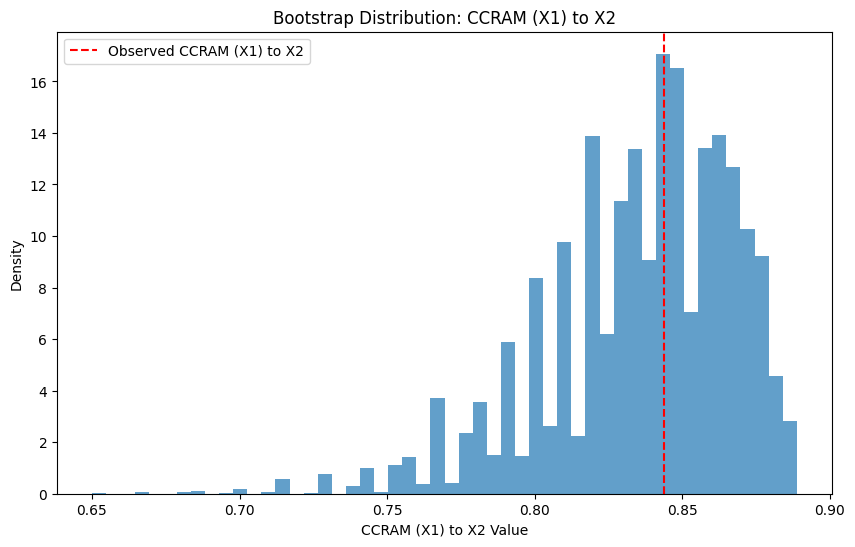

In [5]:
ccram_result = bootstrap_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    confidence_level=0.95,
    method="percentile",
    n_resamples=9999
)

In [6]:
print(f"Metric Name: {ccram_result.metric_name}")
print(f"Observed Value: {ccram_result.observed_value:.4f}")
print(f"95% CI: ({ccram_result.confidence_interval[0]:.4f}, {ccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {ccram_result.standard_error:.4f}")
print(f"Bootstrap Distribution: {type(ccram_result.bootstrap_distribution)}")

Metric Name: CCRAM (X1) to X2
Observed Value: 0.8438
95% CI: (0.7556, 0.8817)
Standard Error: 0.0325
Bootstrap Distribution: <class 'numpy.ndarray'>


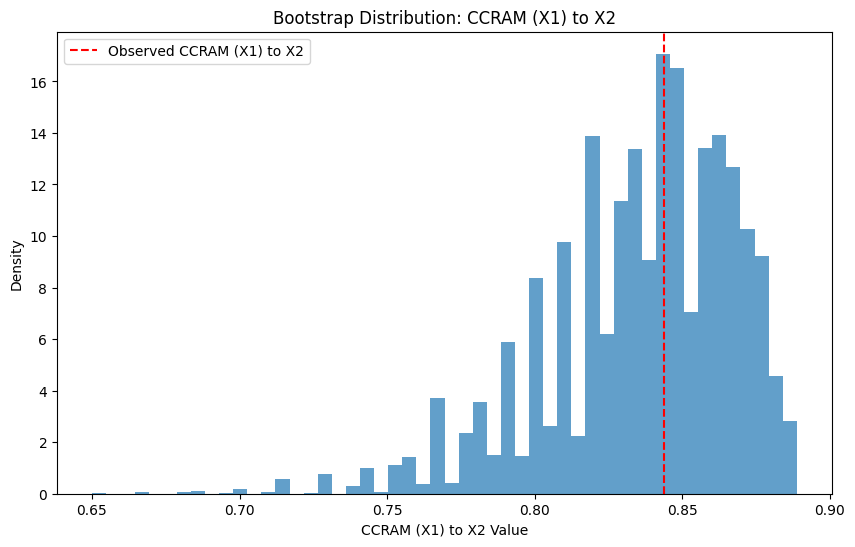

In [7]:
ccram_result.histogram_fig

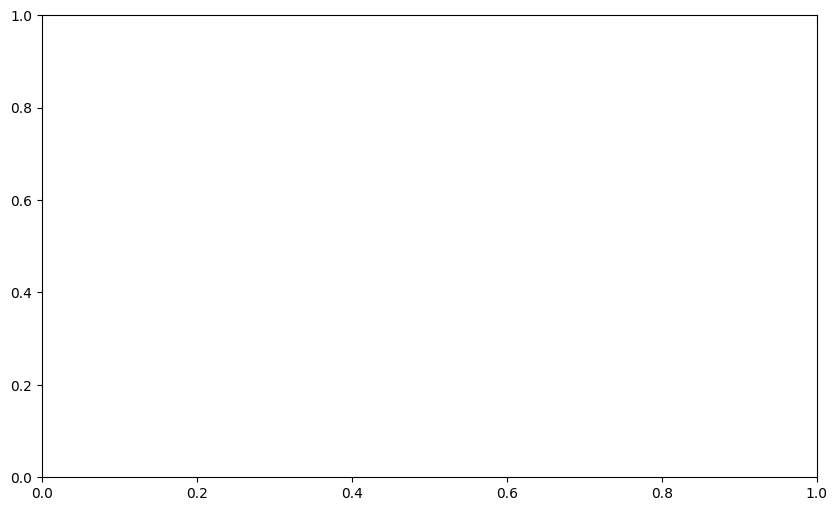

In [8]:
sccram_result = bootstrap_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    scaled=True,
    confidence_level=0.95,
    method="percentile",
    n_resamples=9999
)

In [9]:
print(f"Metric Name: {sccram_result.metric_name}")
print(f"Observed Value: {sccram_result.observed_value:.4f}")
print(f"95% CI: ({sccram_result.confidence_interval[0]:.4f}, {sccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {sccram_result.standard_error:.4f}")
print(f"Bootstrap Distribution: {type(sccram_result.bootstrap_distribution)}")

Metric Name: SCCRAM (X1) to X2
Observed Value: 1.0000
95% CI: (1.0000, 1.0000)
Standard Error: 0.0000
Bootstrap Distribution: <class 'numpy.ndarray'>


### Bootstrap Prediction of Categories through Checkerboard Copula Regression

In [10]:
prediction_matrix = bootstrap_predict_category_summary(
    contingency_table,
    predictors=[1],
    predictors_names=["X"],
    response=2,
    response_name="Y",
    n_resamples=9999
)
print("\nPrediction Matrix:")
prediction_matrix

/Users/dhyeymavani/.pyenv/versions/ccrvam/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/dhyeymavani/.pyenv/versions/ccrvam/lib/python3.13/site-packages/numpy/_core/_methods.py:212: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



Prediction Summary (% of bootstrap samples)
--------------------------------------------------------------------------------
       X=0    X=1    X=2    X=3    X=4
Y=0   0.0%   0.0% 100.0%   0.0%   0.0%
Y=1   0.0% 100.0%   0.0% 100.0%   0.0%
Y=2 100.0%   0.0%   0.0%   0.0% 100.0%
--------------------------------------------------------------------------------

Prediction Matrix:


,X=0,X=1,X=2,X=3,X=4
Y=0,0.0,0.0,100.0,0.0,0.0
Y=1,0.0,100.0,0.0,100.0,0.0
Y=2,100.0,0.0,0.0,0.0,100.0


### Permutation Testing for CCRAM & SCCRAM Metrics

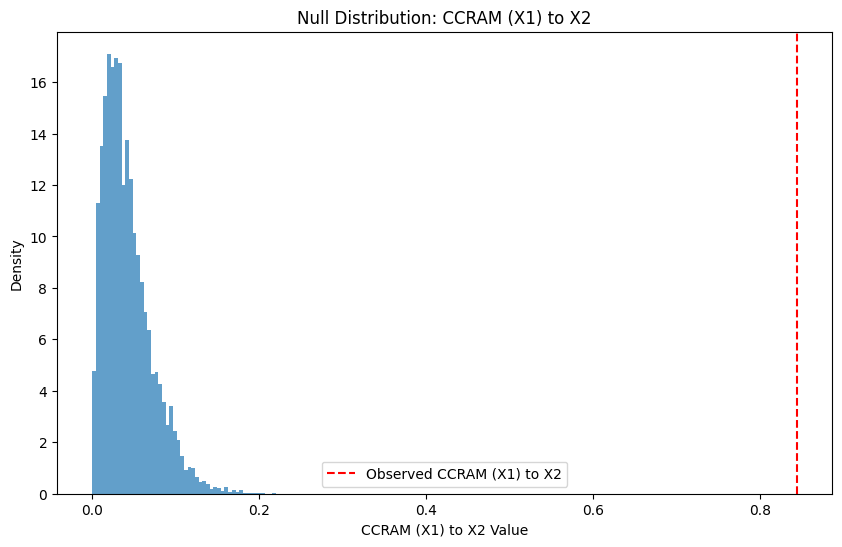

In [11]:
perm_result = permutation_test_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    alternative='greater',
    n_resamples=9999
)

In [12]:
print(f"Metric Name: {perm_result.metric_name}")
print(f"Observed Value: {perm_result.observed_value:.4f}")
print(f"P-Value: {perm_result.p_value:.4f}")
print(f"Null Distribution: {type(perm_result.null_distribution)}")

Metric Name: CCRAM (X1) to X2
Observed Value: 0.8438
P-Value: 0.0001
Null Distribution: <class 'numpy.ndarray'>


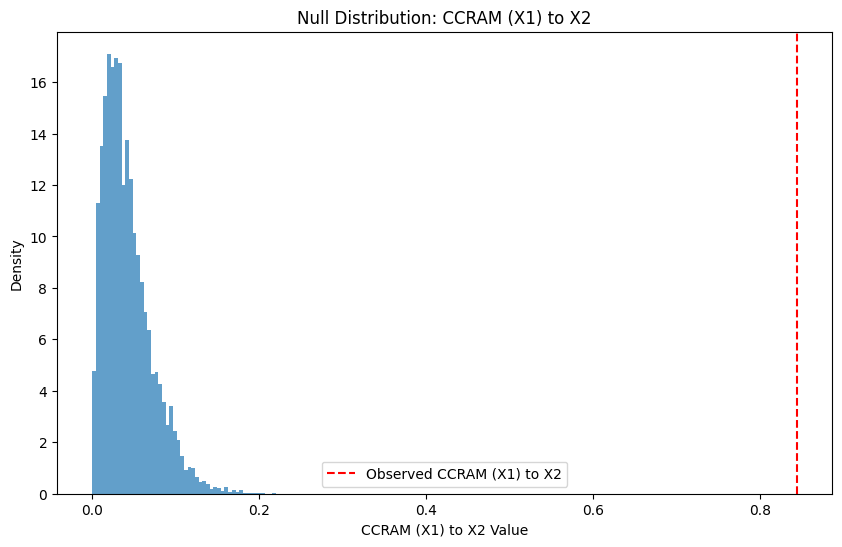

In [13]:
perm_result.histogram_fig

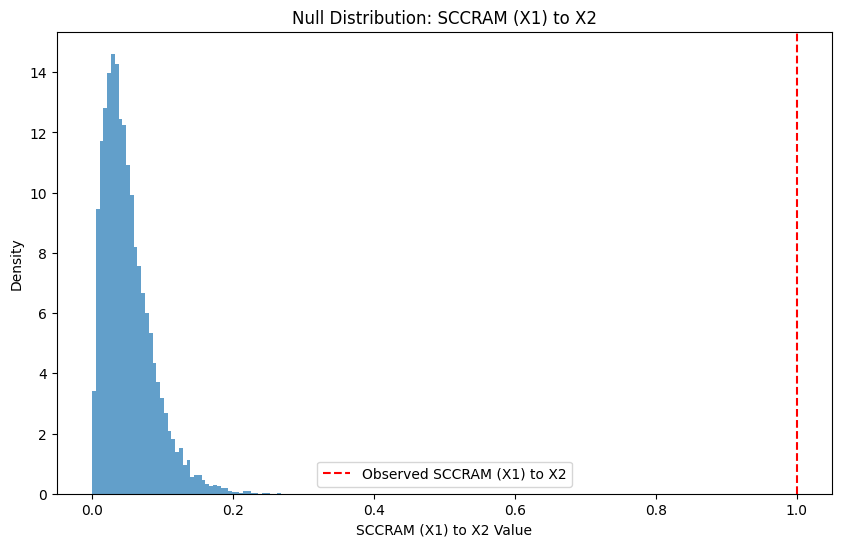

In [14]:
scaled_perm_result = permutation_test_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    scaled=True,
    alternative='greater',
    n_resamples=9999
)

In [15]:
print(f"Metric Name: {scaled_perm_result.metric_name}")
print(f"Observed Value: {scaled_perm_result.observed_value:.4f}")
print(f"P-Value: {scaled_perm_result.p_value:.4f}")
print(f"Null Distribution: {type(scaled_perm_result.null_distribution)}")

Metric Name: SCCRAM (X1) to X2
Observed Value: 1.0000
P-Value: 0.0001
Null Distribution: <class 'numpy.ndarray'>


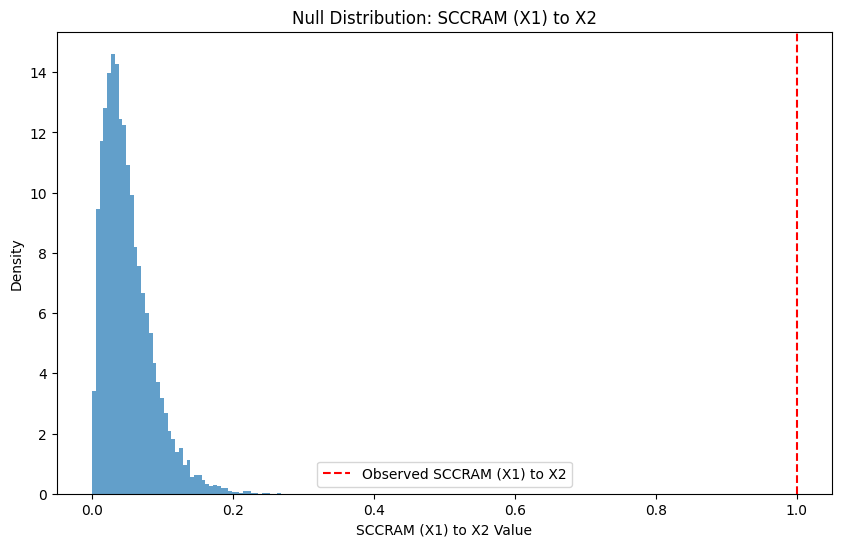

In [16]:
scaled_perm_result.histogram_fig

# 4-Dimensional Case (Real Data Analysis)

### Create Sample Data in Cases Form and Initialize the GenericCheckerboardCopula

The `GenericCheckerboardCopula` can be initialized using categorical data with multiple variables. Let's explain this with a concrete example:

Consider a dataset with 4 categorical variables:
- Length of Previous Attack ($X_1$): 2 categories (Short=1, Long=2)
- Pain Change ($X_2$): 3 categories (Worse=1, Same=2, Better=3)
- Lordosis ($X_3$): 2 categories (absent/decreasing=1, present/increasing=2)
- Back Pain ($X_4$): 6 categories (Worse (W)=1, Same (S)=2, Slight Improvement (SI)=3, Moderate Improvement (MODI)=4, Marked Improvement (MARI)=5, Complete Relief (CR)=6)

In the data structure:
- Each row represents one observation
- Each column represents one categorical variable
- The data is stored as a NumPy array of categorical values starting from 1 to (number of categories)

When creating the copula:
- Variables are numbered from $X_1$ to $X_4$ (in order of presentation in the input data).

In [17]:
real_cases_data = np.array([
    # RDA Row 1
    [1,3,1,2],[1,3,1,5],[1,3,1,5],
    [1,3,1,6],[1,3,1,6],[1,3,1,6],[1,3,1,6],
    # RDA Row 2
    [1,3,2,4],[1,3,2,5],[1,3,2,5],[1,3,2,5],
    # RDA Row 3
    [1,2,1,2],[1,2,1,2],[1,2,1,3],[1,2,1,3],[1,2,1,3],
    [1,2,1,5],[1,2,1,5],[1,2,1,5],[1,2,1,5],[1,2,1,5],[1,2,1,5],
    [1,2,1,6],[1,2,1,6],[1,2,1,6],[1,2,1,6],
    # RDA Row 4
    [1,2,2,2],[1,2,2,4],[1,2,2,4],[1,2,2,6],
    # RDA Row 5
    [1,1,1,5],[1,1,1,5],[1,1,1,6],[1,1,1,6],
    # RDA Row 6
    [1,1,2,3],[1,1,2,4],[1,1,2,5],[1,1,2,5],[1,1,2,5],
    # RDA Row 7
    [2,3,1,3],[2,3,1,3],[2,3,1,3],[2,3,1,5],[2,3,1,6],[2,3,1,6],
    # RDA Row 8
    [2,3,2,2],[2,3,2,5],[2,3,2,5],[2,3,2,5],
    # RDA Row 9
    [2,2,1,2],[2,2,1,2],[2,2,1,2],[2,2,1,3],[2,2,1,3],[2,2,1,3],[2,2,1,3],
    [2,2,1,4],[2,2,1,4],[2,2,1,4],[2,2,1,4],[2,2,1,4],
    [2,2,1,5],[2,2,1,5],[2,2,1,5],[2,2,1,5],[2,2,1,5],[2,2,1,5],
    [2,2,1,6],[2,2,1,6],
    # RDA Row 10
    [2,2,2,1],[2,2,2,2],[2,2,2,2],[2,2,2,2],[2,2,2,2],
    [2,2,2,3],[2,2,2,3],[2,2,2,3],[2,2,2,3],
    [2,2,2,4],[2,2,2,4],[2,2,2,4],[2,2,2,6],
    # RDA Row 11
    [2,1,1,1],[2,1,1,1],[2,1,1,2],[2,1,1,2],[2,1,1,3],
    [2,1,1,4],[2,1,1,4],[2,1,1,4],[2,1,1,4],[2,1,1,4],
    [2,1,1,5],[2,1,1,5],
    # RDA Row 12
    [2,1,2,1],[2,1,2,1],[2,1,2,3],[2,1,2,3],
    [2,1,2,4],[2,1,2,4],[2,1,2,4]
])

rda_copula = GenericCheckerboardCopula.from_cases(cases=real_cases_data, shape=(2,3,2,6))
print(f"Shape of the inferred joint probability matrix P: {rda_copula.P.shape}")
print(f"Probability matrix P:\n{rda_copula.P}\n")

for idx, marginal_pdf in rda_copula.marginal_pdfs.items():
    print(f"Marginal pdf for X{idx+1}: {marginal_pdf}")

for idx, marginal_cdf in rda_copula.marginal_cdfs.items():
    print(f"Marginal cdf for X{idx+1}: {marginal_cdf}")

Shape of the inferred joint probability matrix P: (2, 3, 2, 6)
Probability matrix P:
[[[[0.         0.         0.         0.         0.01980198 0.01980198]
   [0.         0.         0.00990099 0.00990099 0.02970297 0.        ]]

  [[0.         0.01980198 0.02970297 0.         0.05940594 0.03960396]
   [0.         0.00990099 0.         0.01980198 0.         0.00990099]]

  [[0.         0.00990099 0.         0.         0.01980198 0.03960396]
   [0.         0.         0.         0.00990099 0.02970297 0.        ]]]


 [[[0.01980198 0.01980198 0.00990099 0.04950495 0.01980198 0.        ]
   [0.01980198 0.         0.01980198 0.02970297 0.         0.        ]]

  [[0.         0.02970297 0.03960396 0.04950495 0.05940594 0.01980198]
   [0.00990099 0.03960396 0.03960396 0.02970297 0.         0.00990099]]

  [[0.         0.         0.02970297 0.         0.00990099 0.01980198]
   [0.         0.00990099 0.         0.         0.02970297 0.        ]]]]

Marginal pdf for X1: [0.38613861 0.61386139]
Ma

In [18]:
rda_contingency_table = rda_copula.contingency_table
print(f"Shape of the inferred contingency table: {rda_contingency_table.shape}")
print(f"Contingency Table:\n{rda_contingency_table}")

Shape of the inferred contingency table: (2, 3, 2, 6)
Contingency Table:
[[[[0 0 0 0 2 2]
   [0 0 1 1 3 0]]

  [[0 2 3 0 6 4]
   [0 1 0 2 0 1]]

  [[0 1 0 0 2 4]
   [0 0 0 1 3 0]]]


 [[[2 2 1 5 2 0]
   [2 0 2 3 0 0]]

  [[0 3 4 5 6 2]
   [1 4 4 3 0 1]]

  [[0 0 3 0 1 2]
   [0 1 0 0 3 0]]]]


### Bootstrapping CCRAM & SCCRAM Metrics

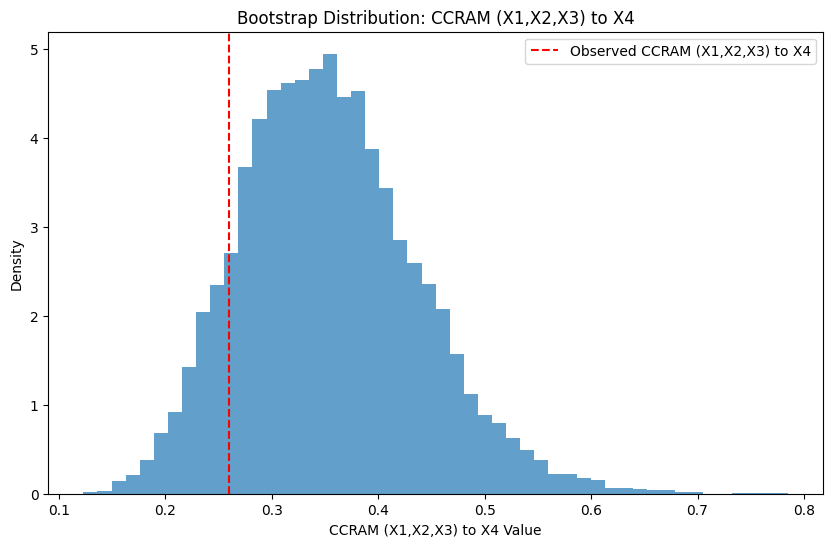

In [19]:
rda_ccram_result = bootstrap_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    confidence_level=0.95,
    method="percentile",
    n_resamples=9999
)

In [20]:
print(f"Metric Name: {rda_ccram_result.metric_name}")
print(f"Observed Value: {rda_ccram_result.observed_value:.4f}")
print(f"95% CI: ({rda_ccram_result.confidence_interval[0]:.4f}, {rda_ccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {rda_ccram_result.standard_error:.4f}")
print(f"Bootstrap Distribution: {type(rda_ccram_result.bootstrap_distribution)}")

Metric Name: CCRAM (X1,X2,X3) to X4
Observed Value: 0.2604
95% CI: (0.2099, 0.5377)
Standard Error: 0.0837
Bootstrap Distribution: <class 'numpy.ndarray'>


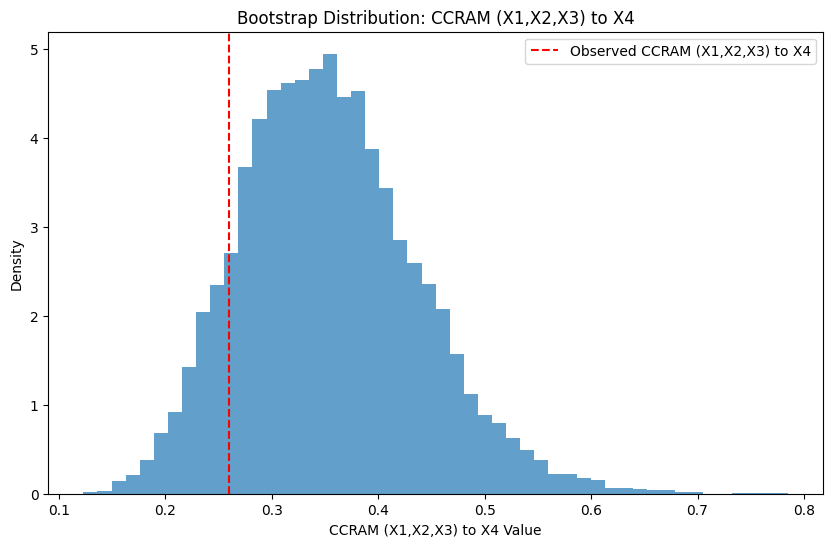

In [21]:
rda_ccram_result.histogram_fig

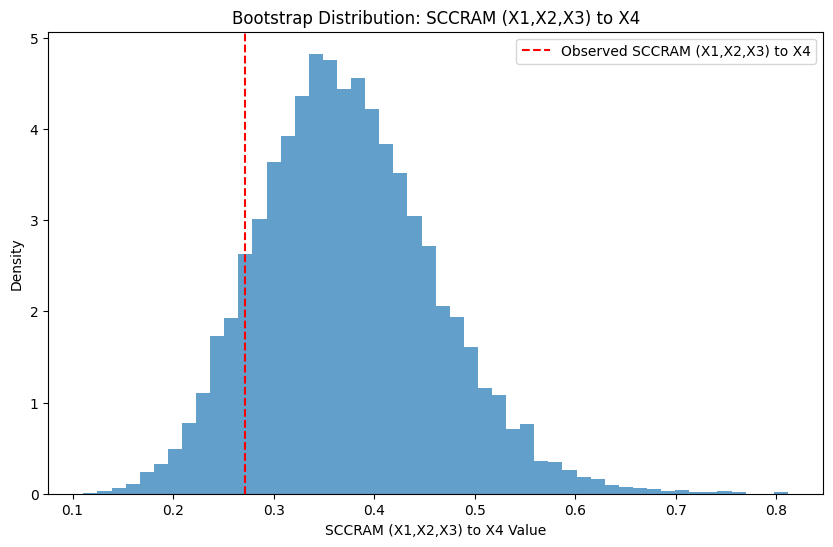

In [22]:
rda_sccram_result = bootstrap_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    confidence_level=0.95,
    scaled=True,
    method="percentile",
    n_resamples=9999
)

In [23]:
print(f"Metric Name: {rda_sccram_result.metric_name}")
print(f"Observed Value: {rda_sccram_result.observed_value:.4f}")
print(f"95% CI: ({rda_sccram_result.confidence_interval[0]:.4f}, {rda_sccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {rda_sccram_result.standard_error:.4f}")
print(f"Bootstrap Distribution: {type(rda_sccram_result.bootstrap_distribution)}")

Metric Name: SCCRAM (X1,X2,X3) to X4
Observed Value: 0.2716
95% CI: (0.2192, 0.5588)
Standard Error: 0.0878
Bootstrap Distribution: <class 'numpy.ndarray'>


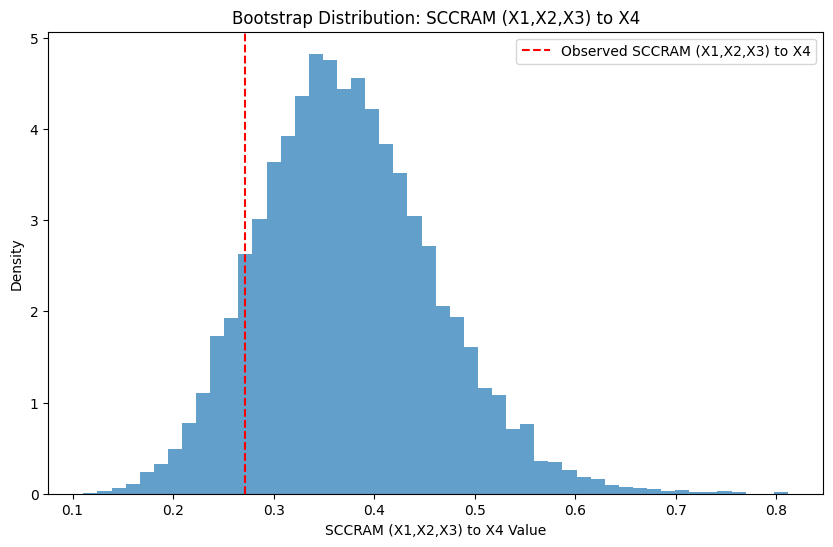

In [24]:
rda_sccram_result.histogram_fig

### Bootstrap Prediction of Categories through Checkerboard Copula Regression

In [25]:
rda_prediction_matrix = bootstrap_predict_category_summary(
    rda_contingency_table,
    predictors=[1, 2, 3],
    predictors_names=["X1", "X2", "X3"],
    response=4,
    response_name="Y = X4",
    n_resamples=9999
)
print("\nPrediction Matrix:")
rda_prediction_matrix

/Users/dhyeymavani/.pyenv/versions/ccrvam/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/dhyeymavani/.pyenv/versions/ccrvam/lib/python3.13/site-packages/numpy/_core/_methods.py:212: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



Prediction Summary (% of bootstrap samples)
--------------------------------------------------------------------------------
           X1=0                                      X1=1                                   
           X2=0          X2=1          X2=2          X2=0          X2=1          X2=2       
           X3=0   X3=1   X3=0   X3=1   X3=0   X3=1   X3=0   X3=1   X3=0   X3=1   X3=0   X3=1
Y = X4=0   1.6%   0.0%   0.1%   0.0%   0.0%   0.2%   0.7%   1.8%   1.7%   0.8%   0.0%   1.8%
Y = X4=1   0.0%   0.0%   0.1%   1.7%   0.0%   0.0%   0.0%   3.6%   0.0%  11.5%   4.5%   3.4%
Y = X4=2   0.0%   0.6%   0.4%  52.4%   3.1%   7.9%   2.3%  17.4%   0.0%  71.5%  76.8%   6.8%
Y = X4=3   0.0%  33.9%   7.1%  45.6%  82.4%  41.9%  41.5%  47.9%  11.1%  16.1%  18.6%  35.7%
Y = X4=4  65.8%  65.5%  71.2%   0.3%  14.5%  46.8%  55.5%  26.1%  87.2%   0.0%   0.1%  52.3%
Y = X4=5  32.5%   0.1%  21.1%   0.0%   0.0%   3.1%   0.0%   3.3%   0.0%   0.0%   0.0%   0.0%
-------------------------------------

X1=0                                                         \
               X2=0                  X2=1                  X2=2              
               X3=0       X3=1       X3=0       X3=1       X3=0       X3=1   
Y = X4=0   1.640164   0.000000   0.080008   0.010001   0.000000   0.220022   
Y = X4=1   0.000000   0.000000   0.110011   1.720172   0.000000   0.000000   
Y = X4=2   0.000000   0.580058   0.440044  52.415242   3.100310   7.920792   
Y = X4=3   0.000000  33.873387   7.120712  45.574557  82.448245  41.894189   
Y = X4=4  65.816582  65.486549  71.177118   0.280028  14.451445  46.824682   
Y = X4=5  32.543254   0.060006  21.072107   0.000000   0.000000   3.140314   

               X1=1                                                         
               X2=0                  X2=1                  X2=2             
               X3=0       X3=1       X3=0       X3=1       X3=0       X3=1  
Y = X4=0   0.660066   1.830183   1.710171   0.800080   0.000000   1.820182  
Y = X4=1   0.000000   3.570357   0.000000  11.541154   4.490449   3.390339  
Y = X4=2   2.340234  17.351735   0.000000  71.547155  76.807681   6.800680  
Y = X4=3  41.544154  47.874787  11.071107  16.111611  18.561856  35.673567  
Y = X4=4  55.455546  26.122612  87.218722   0.000000   0.140014  52.315232  
Y = X4=5   0.000000   3.250325   0.000000   0.000000   0.000000   0.000000

### Permutation Testing for CCRAM & SCCRAM Metrics

/Users/dhyeymavani/.pyenv/versions/ccrvam/lib/python3.13/site-packages/scipy/stats/_resampling.py:1492: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


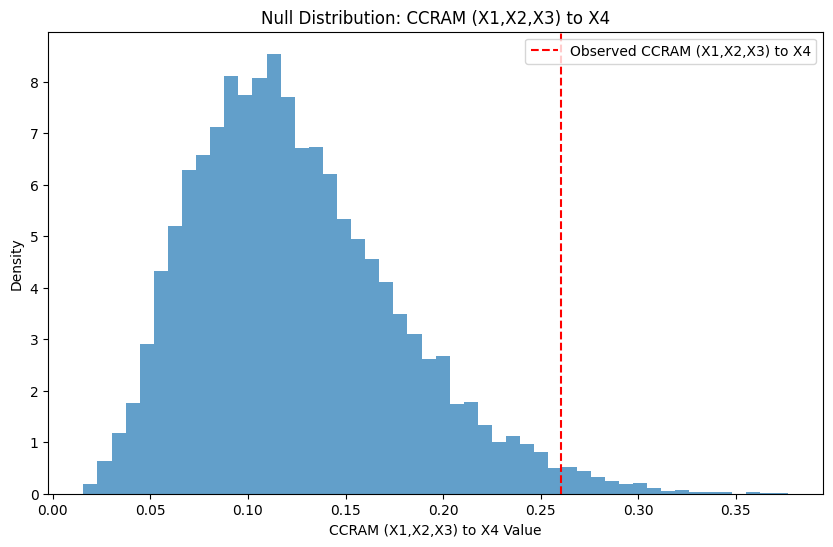

In [26]:
rda_perm_result = permutation_test_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    alternative='greater',
    n_resamples=9999
)

In [27]:
print(f"Metric Name: {rda_perm_result.metric_name}")
print(f"Observed Value: {rda_perm_result.observed_value:.4f}")
print(f"P-Value: {rda_perm_result.p_value:.4f}")
print(f"Null Distribution: {type(rda_perm_result.null_distribution)}")

Metric Name: CCRAM (X1,X2,X3) to X4
Observed Value: 0.2604
P-Value: 0.0174
Null Distribution: <class 'numpy.ndarray'>


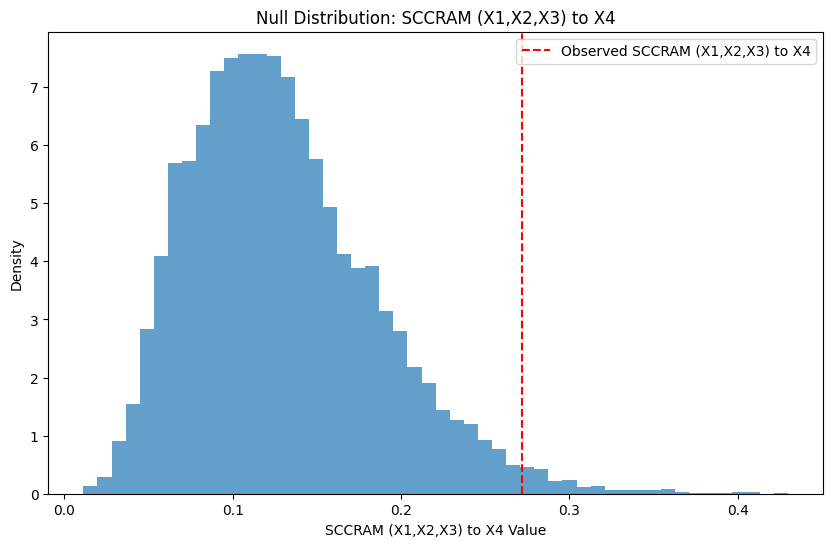

In [28]:
rda_scaled_perm_result = permutation_test_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    scaled=True,
    alternative='greater',
    n_resamples=9999
)

In [29]:
print(f"Metric Name: {rda_scaled_perm_result.metric_name}")
print(f"Observed Value: {rda_scaled_perm_result.observed_value:.4f}")
print(f"P-Value: {rda_scaled_perm_result.p_value:.4f}")
print(f"Null Distribution: {type(rda_scaled_perm_result.null_distribution)}")

Metric Name: SCCRAM (X1,X2,X3) to X4
Observed Value: 0.2716
P-Value: 0.0172
Null Distribution: <class 'numpy.ndarray'>
